In [1]:
from field_importer import get_field
from cartoplot import cartoplot
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
%config Completer.use_jedi = False

In [2]:
monthlist = ["10","11","12","01","02","03","04"]

yearlist = list(range(2003,2019))


month_diffs = {}

for month in monthlist:
    
    yearlist = range(2002,2018) if month in ['10','11','12'] else range(2003,2019)
    
    month_diffs[month] = []

    for year in yearlist:

        M2_SWE = get_field('SnowModel',month,year,resolution=361,variable='M2 depth')
        E5_SWE = get_field('SnowModel',month,year,resolution=361,variable='E5 depth')
        
        diff = np.abs(E5_SWE['field'] - M2_SWE['field'])*100
        
        month_diffs[month].append(diff)

In [3]:
month_ave_diffs = {}

for key in month_diffs.keys():
    
    ave = np.mean(month_diffs[key], axis=0)
    
    month_ave_diffs[key] = ave
    

    

In [4]:
region_codes = {
        "Barents":8,
        "Kara":9,
        "Laptev":10,
        "East Siberian":11,
        "Chukchi":12,
        "Beaufort":13,
        "Central Arctic":15}

regions_l = list(region_codes.keys())

In [5]:
month_names = {"10":'Oct',
               "11":'Nov',
               "12":'Dec',
               "01":'Jan',
               "02":'Feb',
               "03":'Mar',
               "04":'Apr',
              }

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


['Barents', 'Kara', 'Laptev', 'East Siberian', 'Chukchi', 'Beaufort', 'Central Arctic']


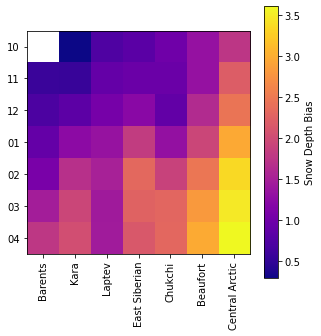

In [6]:
mask_dir = '/home/robbie/Dropbox/Code/mask.nc'
mask_data = Dataset(mask_dir)

lon, lat =np.array(mask_data['lon']), np.array(mask_data['lat'])
my_mask = np.array(mask_data['mask_values'])

regional_diffs = {}

for key in month_ave_diffs:
    
    regional_diffs[key] = {}
    
    for region in regions_l:
        
        region_err = ma.masked_where(my_mask != region_codes[region], month_ave_diffs[key])
        region_err = np.ma.filled(region_err.astype(float), np.nan)
        mean_error = np.nanmean(region_err)
        
        regional_diffs[key][region] = mean_error
        
hmap = np.full((len(regions_l),len(monthlist)),np.nan)

for monthcounter, month in enumerate(monthlist):

    for regioncounter, region in enumerate(regions_l):
        
        hmap[monthcounter,regioncounter] = regional_diffs[month][region]

print(regions_l)
    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xticklabels([""]+regions_l,rotation=90)
ax.set_yticklabels([""]+monthlist)

h = ax.imshow(hmap, cmap='plasma')
cb = fig.colorbar(h)
cb.set_label('Snow Depth Bias')

In [7]:
print(regional_diffs)

{'10': {'Barents': nan, 'Kara': 0.2941158413887024, 'Laptev': 0.7344952630334927, 'East Siberian': 0.8374955113977194, 'Chukchi': 0.9977812929586931, 'Beaufort': 1.3379096216447453, 'Central Arctic': 1.7663454407921075}, '11': {'Barents': 0.5764481183831338, 'Kara': 0.5598463885081535, 'Laptev': 0.9135720367082422, 'East Siberian': 0.9672981684875936, 'Chukchi': 0.9671229666968186, 'Beaufort': 1.3316766707734629, 'Central Arctic': 2.205835724387284}, '12': {'Barents': 0.7094726612971675, 'Kara': 0.8393557368266251, 'Laptev': 1.0601953277516305, 'East Siberian': 1.2279418767846408, 'Chukchi': 0.900221723967943, 'Beaufort': 1.6331719239193834, 'Central Arctic': 2.463949741342418}, '01': {'Barents': 0.9128781261317658, 'Kara': 1.2596360757457754, 'Laptev': 1.3517253426398876, 'East Siberian': 1.831775927660512, 'Chukchi': 1.3253254729786912, 'Beaufort': 1.945667777225996, 'Central Arctic': 2.9681077916867276}, '02': {'Barents': 1.0935026691908516, 'Kara': 1.6985092019120014, 'Laptev': 1.5

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


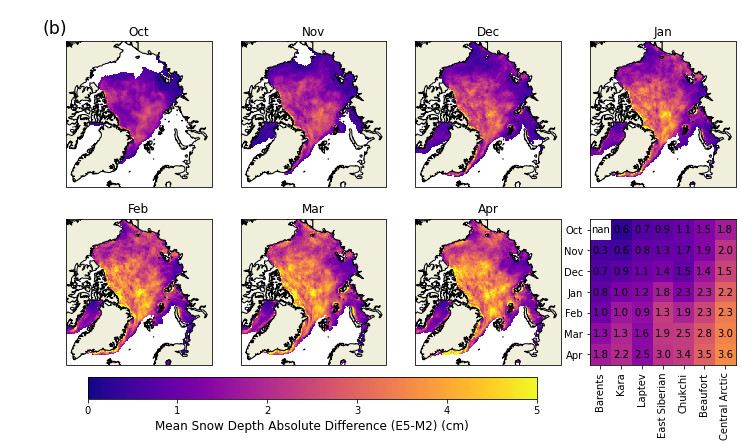

In [10]:
fig = plt.figure(figsize=(12,6))

vmin = 0; vmax = 5 

for counter, key in enumerate(month_ave_diffs.keys()) :
    
    ave = month_ave_diffs[key]
    
    
    ax = fig.add_subplot(2,4,counter+1,projection=ccrs.NorthPolarStereo())

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
    ax.set_title(month_names[key])
    ax.pcolormesh(M2_SWE['lon'], M2_SWE['lat'], ave[:-1,:-1], vmin = vmin, vmax = vmax,
                 transform=ccrs.PlateCarree(),cmap='plasma')
    
    
ax = fig.add_subplot(2,4,8,)
ax.set_xticks(np.arange(len(regions_l)))
ax.set_xticklabels(regions_l,rotation=90)
ax.set_yticklabels([""]+list(month_names.values()))
h = ax.imshow(hmap, cmap='plasma', vmin = vmin, vmax = vmax)


for mcount, month in enumerate(monthlist):
    for rcount, region in enumerate(regions_l):
        ax.annotate(f'{np.round(hmap[mcount,rcount],decimals=1)}',
                    xy=(mcount,rcount),
                    color='k',
                    alpha=1,
                    xycoords='data', ha='center', va='center',fontsize='medium')

cax = fig.add_axes([0.15, 0.05, 0.52, 0.05])
cb = fig.colorbar(h, cax=cax, orientation='horizontal')
cb.set_label('Mean Snow Depth Absolute Difference (E5-M2) (cm)', fontsize='large')
cb.set_ticks(np.arange(vmin,vmax+1,1))

plt.annotate('(b)', (0.057,0.925), xycoords='figure fraction', fontsize='xx-large')

plt.savefig(f"SM_reanalysis_maps_b.png",
                dpi=450, bbox_inches='tight')

In [11]:
str_to_pass = f'convert SM_reanalysis_maps_a.png SM_reanalysis_maps_b.png -append SM_reanalysis_maps_comp.png'
!{str_to_pass}

In [12]:
dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper_v2'

str_to_pass = f'cp SM_reanalysis_maps_comp.png {dir_to_save}/Sup_Figs/SM_reanalysis_maps_comp.png'

!{str_to_pass}